In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
import seaborn as sns

In [93]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


In [94]:
# Upload data (you may need to upload manually in Google Colab)
from google.colab import files
uploaded = files.upload()
mcdonalds = pd.read_csv("mcdonalds.csv")

In [95]:
print(mcdonalds.head())

  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   
3   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes        No      No   
4    No        Yes    No       Yes    Yes  Yes   Yes    No        No     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  
3        Yes   +4   69         Once a week  Female  
4         No   +2   49        Once a month    Male  


In [96]:
print(mcdonalds.columns)

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')


In [97]:
print(mcdonalds.shape)

(1453, 15)


In [98]:
# Apply binary transformation to the categorical columns
MD_x = mcdonalds.iloc[:, :11]
MD_x = MD_x.applymap(lambda x: 1 if x == 'Yes' else 0)

In [99]:
print(MD_x.mean())

yummy         0.552650
convenient    0.907777
spicy         0.093599
fattening     0.867171
greasy        0.526497
fast          0.900206
cheap         0.598761
tasty         0.644184
expensive     0.357880
healthy       0.198899
disgusting    0.242946
dtype: float64


In [100]:
# Standardize the data
scaler = StandardScaler()
MD_x_scaled = scaler.fit_transform(MD_x)

In [101]:
# Apply PCA
pca = PCA()
MD_pca = pca.fit_transform(MD_x_scaled)

In [102]:
# Print PCA results
print(pca.explained_variance_ratio_)
print(pca.components_)

[0.25556637 0.14834762 0.12546909 0.09826971 0.08348356 0.07109102
 0.06498559 0.05384477 0.04762809 0.02796379 0.0233504 ]
[[ 0.40695508  0.30882741  0.02332033 -0.17786071 -0.26779582  0.21303906
   0.28913434  0.42611499 -0.29094445  0.26683857 -0.41074387]
 [-0.28261487  0.04568172 -0.0699822   0.20559024  0.13630029  0.28244059
   0.57503178 -0.24219851 -0.56752776 -0.20103082  0.14388846]
 [ 0.25958798  0.31715142 -0.0201696   0.60807736  0.38956798  0.21139458
  -0.1251574   0.26964779  0.18329788 -0.36781371 -0.09029919]
 [ 0.02623694 -0.00942396  0.84549641 -0.02339555  0.33085439  0.09036315
   0.11447698  0.0726908   0.03550987  0.30198954  0.23523093]
 [-0.34685741  0.43714795  0.185551   -0.08693385 -0.3437128   0.56893862
  -0.25698101 -0.2860986   0.20736179 -0.05178742 -0.10584327]
 [ 0.12491568 -0.18896641 -0.43866119 -0.1075199   0.27832865  0.57273434
  -0.02065707  0.05305267  0.17116009  0.4461664   0.32804054]
 [-0.15987822  0.66181418 -0.21418844  0.0238514   0.3

In [103]:
# Summary of PCA
SD = np.sqrt(pca.explained_variance_)
PV = pca.explained_variance_ratio_
index = ["PC{}".format(i+1) for i in range(len(SD))]
summary = pd.DataFrame({
    "Standard deviation": SD,
    "Proportion of Variance": PV,
    "Cumulative Proportion": PV.cumsum()
}, index=index)
print(summary.round(4))

      Standard deviation  Proportion of Variance  Cumulative Proportion
PC1               1.6772                  0.2556                 0.2556
PC2               1.2779                  0.1483                 0.4039
PC3               1.1752                  0.1255                 0.5294
PC4               1.0401                  0.0983                 0.6277
PC5               0.9586                  0.0835                 0.7111
PC6               0.8846                  0.0711                 0.7822
PC7               0.8458                  0.0650                 0.8472
PC8               0.7699                  0.0538                 0.9011
PC9               0.7241                  0.0476                 0.9487
PC10              0.5548                  0.0280                 0.9766
PC11              0.5070                  0.0234                 1.0000


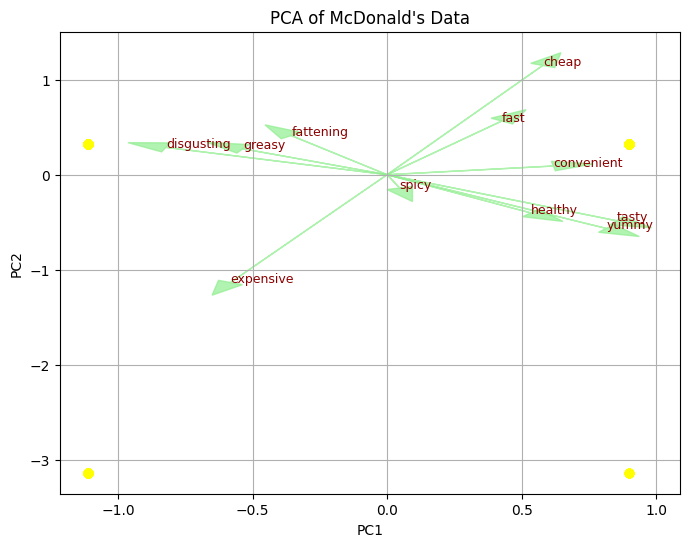

In [123]:
plt.figure(figsize=(8, 6))
plt.scatter(MD_x_scaled[:, 0],MD_x_scaled[:, 1], color='yellow', label='Consumers')
# Adding arrows for variable loadings (component loadings)
for i, feature in enumerate(MD_x.columns):
    plt.arrow(0, 0,
              pca.components_[0, i] * 2.0,  # Scale arrow length
              pca.components_[1, i] * 2.0,
              color='lightgreen', alpha=0.7, head_width=0.1, head_length=0.15)
    plt.text(pca.components_[0, i] * 2.0,
             pca.components_[1, i] * 2.0,
             feature, color='darkred',fontsize=9
            )
    plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of McDonald\'s Data')
plt.grid(True)
plt.show()

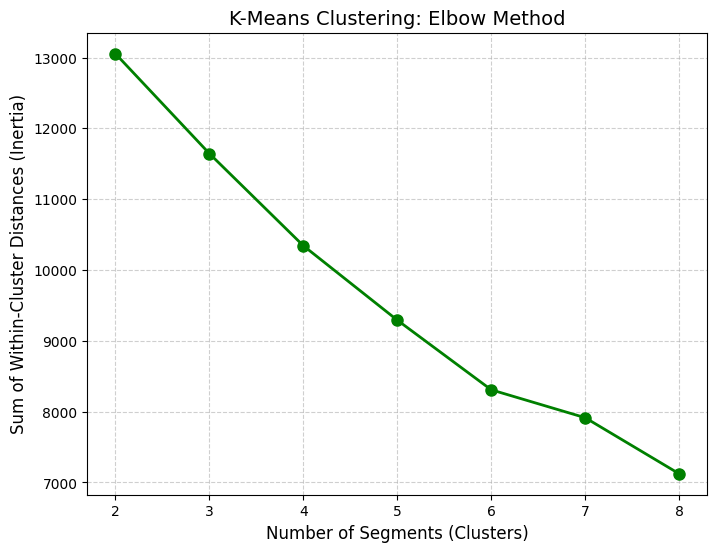

In [105]:
# Perform K-Means clustering for cluster numbers ranging from 2 to 8
np.random.seed(1234)
inertia = []  # To store the sum of within-cluster distances (inertia)
labels_dict = {}  # To store the cluster labels for each k

# Loop through the desired range of clusters
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(MD_x_scaled)  # Use the scaled dataset
    inertia.append(kmeans.inertia_)  # Store the inertia (within-cluster sum of squares)
    labels_dict[k] = kmeans.labels_  # Store the labels for each number of clusters

# Plot inertia to visualize the "elbow" point
plt.figure(figsize=(8, 6))
plt.plot(range(2, 9), inertia, marker='o', color='g', linestyle='-', linewidth=2, markersize=8)
plt.xlabel("Number of Segments (Clusters)", fontsize=12)
plt.ylabel("Sum of Within-Cluster Distances (Inertia)", fontsize=12)
plt.title("K-Means Clustering: Elbow Method", fontsize=14)
plt.xticks(range(2, 9), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


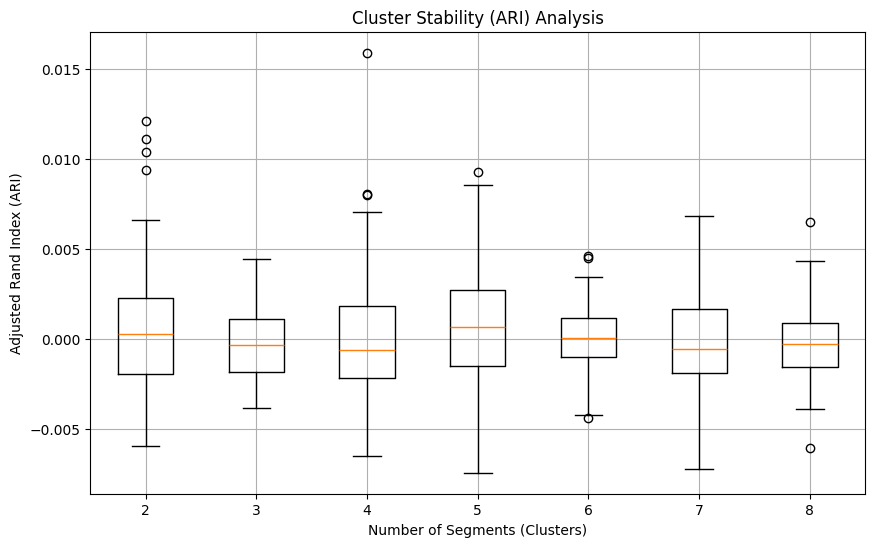

In [106]:
# Boxplot showing the cluster stability analysis (ARI scores)
plt.figure(figsize=(10, 6))
plt.boxplot([stability_scores[k] for k in range(2, 9)], positions=range(2, 9))
plt.xlabel("Number of Segments (Clusters)")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.title("Cluster Stability (ARI) Analysis")
plt.grid(True)
plt.show()


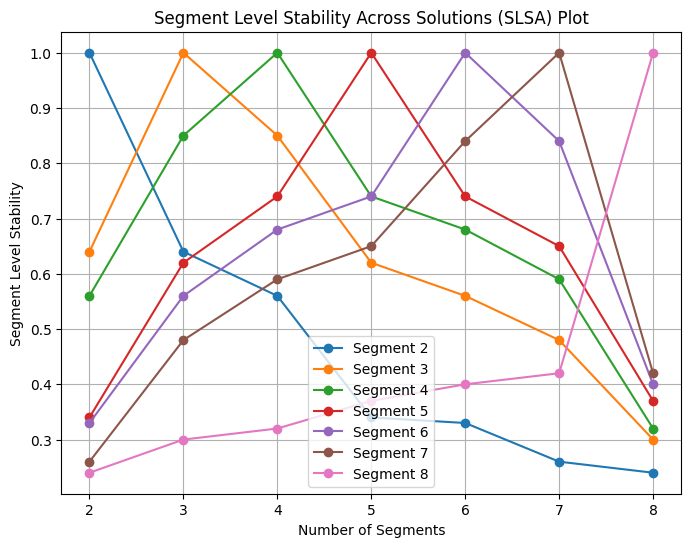

In [107]:
MD_x = np.random.rand(100, 2)
# Scale data
scaler = StandardScaler()
MD_x_scaled = scaler.fit_transform(MD_x)

# Dictionary to store KMeans models for each number of clusters
MD_x_km28 = {}

# Fit KMeans models for 2 to 8 clusters and store them
for segment in range(2, 9):
    kmeans = KMeans(n_clusters=segment, random_state=42)
    kmeans.fit(MD_x_scaled)
    MD_x_km28[str(segment)] = kmeans  # Save the model in the dictionary

# Now compute the segment stability
num_segments = range(2, 9)
segment_stability = []

# Compute stability for each segment (cluster count)
for segment in num_segments:
    labels_segment = MD_x_km28[str(segment)].predict(MD_x_scaled)
    segment_stability.append(labels_segment)

# Plotting the segment stability
plt.figure(figsize=(8, 6))
for i, segment in enumerate(num_segments):
    plt.plot(num_segments, [np.mean(segment_stability[i] == labels) for labels in segment_stability], marker='o', label=f'Segment {segment}')

plt.xlabel('Number of Segments')
plt.ylabel('Segment Level Stability')
plt.title('Segment Level Stability Across Solutions (SLSA) Plot')
plt.xticks(num_segments)
plt.legend()
plt.grid(True)

plt.show()

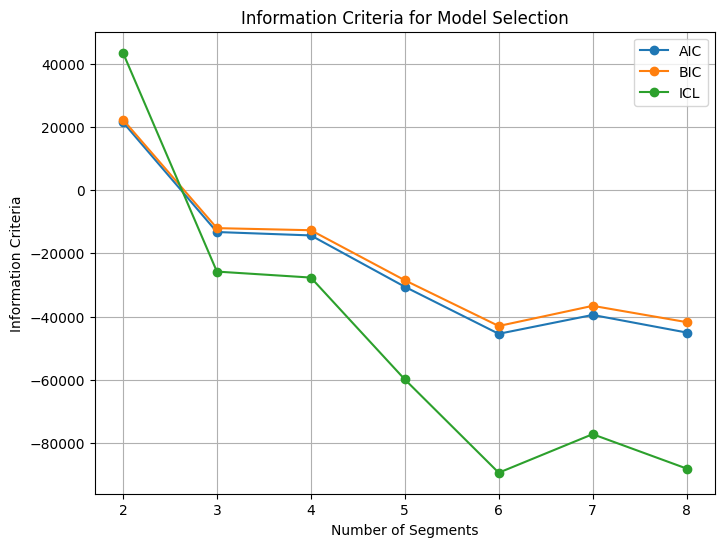

In [119]:
aic_values, bic_values, icl_values = [], [], []

for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, random_state=1234).fit(MD_x_scaled)
    aic_values.append(gmm.aic(MD_x_scaled))
    bic_values.append(gmm.bic(MD_x_scaled))
    icl_values.append(bic_values[-1] - 2 * gmm.score_samples(MD_x_scaled).sum())

# Plot information criteria
plt.figure(figsize=(8, 6))
plt.plot(range(2, 9), aic_values, label='AIC', marker='o')
plt.plot(range(2, 9), bic_values, label='BIC', marker='o')
plt.plot(range(2, 9), icl_values, label='ICL', marker='o')
plt.xlabel('Number of Segments')
plt.ylabel('Information Criteria')
plt.title('Information Criteria for Model Selection')
plt.legend()
plt.grid(True)
plt.show()


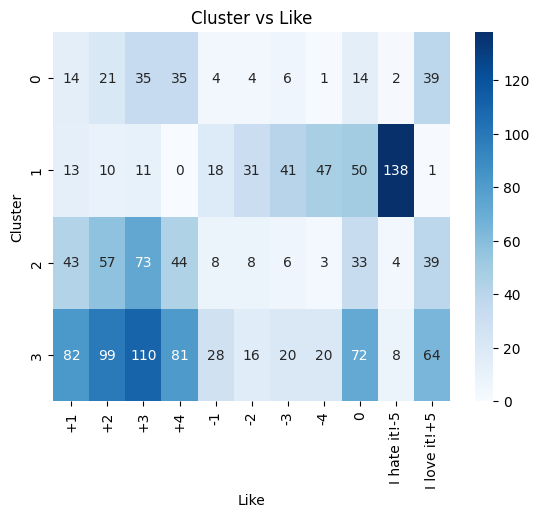

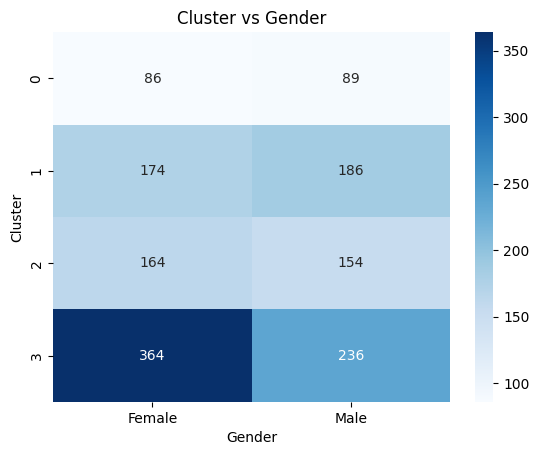

In [108]:
# Perform K-means clustering for 4 clusters
k4 = labels_dict[4]

# Create cluster assignments in the original dataframe
mcdonalds['Cluster'] = k4

# Perform the crosstab and heatmap for "Cluster vs Like"
sns.heatmap(pd.crosstab(mcdonalds['Cluster'], mcdonalds['Like']), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Like")
plt.ylabel("Cluster")
plt.title("Cluster vs Like")
plt.show()

# Perform the crosstab and heatmap for "Cluster vs Gender"
sns.heatmap(pd.crosstab(mcdonalds['Cluster'], mcdonalds['Gender']), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Gender")
plt.ylabel("Cluster")
plt.title("Cluster vs Gender")
plt.show()


In [118]:
# Ensure the K-means labels are properly assigned (replace labels_dict[4] if necessary)
kmeans_labels = kmeans.labels_  # This should give you the K-means cluster labels

# GMM labels (from your GaussianMixture model)
gmm_4_labels = gmm_4_with_kmeans.predict(MD_x_scaled)

# Make sure the lengths match
print("Length of K-means labels:", len(kmeans_labels))
print("Length of GMM labels:", len(gmm_4_labels))

# Create a DataFrame comparing both sets of labels
comparison_df = pd.DataFrame({
    'kmeans': kmeans_labels,
    'gmm': gmm_4_labels
})

# Print the comparison table using a contingency table (cross-tabulation)
print(pd.crosstab(comparison_df['kmeans'], comparison_df['gmm']))



Length of K-means labels: 1453
Length of GMM labels: 1453
gmm       0    1   2    3
kmeans                   
0       679   11   8   51
1         0  123   0    0
2         0    0  48  217
3         0    0   5  311


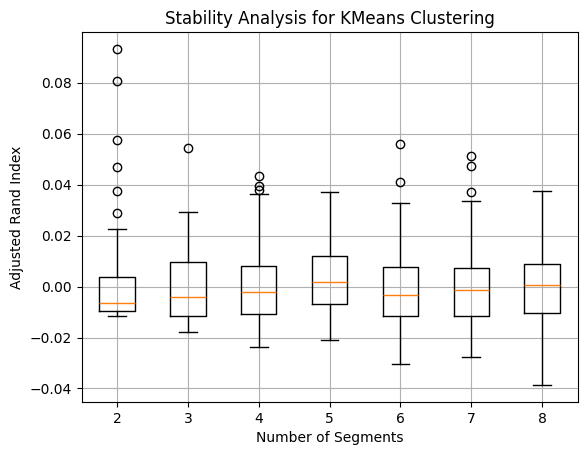

In [111]:
nboot = 100  # Number of bootstrap samples

# Store ARI values for each cluster count
stability_scores = {k: [] for k in range(2, 9)}

# Perform clustering for each k (2 to 8 clusters)
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(MD_x_scaled)
    # Perform bootstrap sampling and calculate ARI
    for _ in range(nboot):
        bootstrap_sample, bootstrap_labels = resample(MD_x_scaled, random_state=np.random.randint(0, 10000)), kmeans.labels_
        kmeans_bootstrap = KMeans(n_clusters=k, n_init=10, random_state=1234)
        kmeans_bootstrap.fit(bootstrap_sample)
        ari = adjusted_rand_score(bootstrap_labels, kmeans_bootstrap.labels_)
        stability_scores[k].append(ari)

# Plot the stability (ARI) for each number of clusters
plt.boxplot([stability_scores[k] for k in range(2, 9)], positions=range(2, 9))
plt.xlabel("Number of Segments")
plt.ylabel("Adjusted Rand Index")
plt.title("Stability Analysis for KMeans Clustering")
plt.xticks(range(2, 9))
plt.grid(True)
plt.show()

In [31]:
from sklearn.metrics import silhouette_score

# Silhouette score for KMeans clustering (4 clusters)
silhouette_kmeans = silhouette_score(MD_x_scaled, labels_dict[4])
print(f"Silhouette Score (KMeans): {silhouette_kmeans:.4f}")

# Silhouette score for GMM clustering (4 clusters)
silhouette_gmm = silhouette_score(MD_x_scaled, gmm_4_with_kmeans.predict(MD_x_scaled))
print(f"Silhouette Score (GMM): {silhouette_gmm:.4f}")

Silhouette Score (KMeans): 0.2177
Silhouette Score (GMM): 0.1893


In [113]:
# Assuming mcdonalds has columns with 'Yes'/'No' values, you can convert them into numeric values
MD_x = mcdonalds.iloc[:, :11]  # Adjust based on your feature selection

# Convert 'Yes'/'No' values into 1/0
MD_x = MD_x.applymap(lambda x: 1 if x == 'Yes' else (0 if x == 'No' else x))

# After conversion, check the data to make sure there are no strings
print(MD_x.head())

# Now you can scale the data
scaler = StandardScaler()
MD_x_scaled = scaler.fit_transform(MD_x)

# Print the shape to confirm scaling has been applied correctly
print("Shape of MD_x_scaled:", MD_x_scaled.shape)

# Fit your Gaussian Mixture Model (GMM)
gmm_4_with_kmeans = GaussianMixture(n_components=4, random_state=1234, init_params='kmeans')
gmm_4_with_kmeans.fit(MD_x_scaled)

# Now predict clusters using GMM
predictions = gmm_4_with_kmeans.predict(MD_x_scaled)

# Check length of predictions and assign to DataFrame if lengths match
if len(predictions) == mcdonalds.shape[0]:
    mcdonalds['Cluster'] = predictions  # Assign predictions to original dataframe
else:
    print("Error: Length mismatch between predictions and DataFrame rows")


   yummy  convenient  spicy  fattening  greasy  fast  cheap  tasty  expensive  \
0      0           1      0          1       0     1      1      0          1   
1      1           1      0          1       1     1      1      1          1   
2      0           1      1          1       1     1      0      1          1   
3      1           1      0          1       1     1      1      1          0   
4      0           1      0          1       1     1      1      0          0   

   healthy  disgusting  
0        0           0  
1        0           0  
2        1           0  
3        0           1  
4        1           0  
Shape of MD_x_scaled: (1453, 11)


In [114]:
from sklearn.mixture import GaussianMixture

# Fit the GMM with K-means initialization
gmm_4_with_kmeans = GaussianMixture(n_components=4, random_state=1234, init_params='kmeans')
gmm_4_with_kmeans.fit(MD_x_scaled)

# Log-Likelihood
print("Log-Likelihood (GMM with K-means init):", gmm_4_with_kmeans.score(MD_x_scaled) * len(MD_x_scaled))


Log-Likelihood (GMM with K-means init): 7484.795146143057


In [115]:
# Get the cluster labels from GMM
gmm_predictions = gmm_4_with_kmeans.predict(MD_x_scaled)

# Add cluster labels to the original dataframe
mcdonalds['Cluster'] = gmm_predictions

# Check the first few rows of the DataFrame with cluster assignments
print(mcdonalds.head())


  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   
3   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes        No      No   
4    No        Yes    No       Yes    Yes  Yes   Yes    No        No     Yes   

  disgusting Like  Age      VisitFrequency  Gender  Cluster  
0         No   -3   61  Every three months  Female        3  
1         No   +2   51  Every three months  Female        0  
2         No   +1   62  Every three months  Female        3  
3        Yes   +4   69         Once a week  Female        3  
4         No   +2   49        Once a month    Male        3  


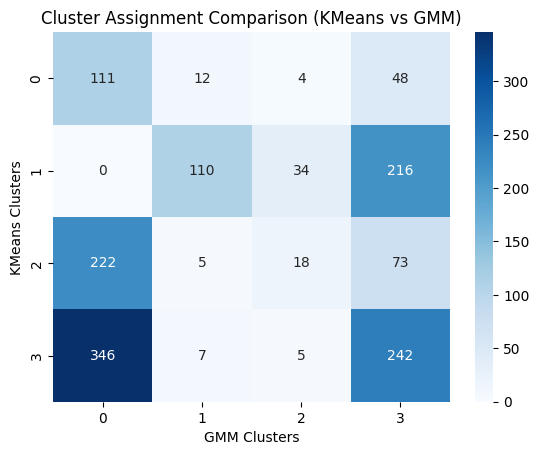

In [33]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for KMeans and GMM clustering results
conf_matrix = confusion_matrix(mcdonalds['KMeans_Cluster'], mcdonalds['GMM_Cluster'])
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("GMM Clusters")
plt.ylabel("KMeans Clusters")
plt.title("Cluster Assignment Comparison (KMeans vs GMM)")
plt.show()


In [120]:
from sklearn.metrics import adjusted_rand_score

# Assuming you already have kmeans and gmm_4_with_kmeans models fitted

# Assign K-means and GMM cluster labels to the DataFrame
mcdonalds['KMeans_Cluster'] = kmeans.labels_  # Assign KMeans labels
mcdonalds['GMM_Cluster'] = gmm_4_with_kmeans.predict(MD_x_scaled)  # Assign GMM labels

# Compute Adjusted Rand Index (ARI) between KMeans and GMM for 4 clusters
ari_score = adjusted_rand_score(mcdonalds['KMeans_Cluster'], mcdonalds['GMM_Cluster'])
print(f"Adjusted Rand Index (KMeans vs GMM): {ari_score:.4f}")



Adjusted Rand Index (KMeans vs GMM): 0.6812


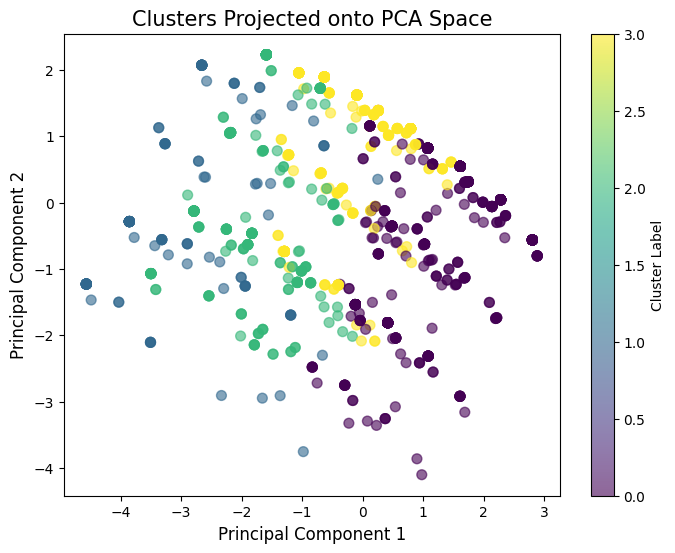

In [117]:
import matplotlib.pyplot as plt

# Assuming MD_x_scaled is your scaled dataset and kmeans is your KMeans object
# Perform KMeans clustering to get cluster labels
from sklearn.cluster import KMeans

# Example: Apply KMeans clustering with 4 clusters (if not done already)
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans.fit(MD_x_scaled)
k4_labels = kmeans.labels_  # This stores the cluster labels

# Scatter plot of clusters projected onto PCA space
plt.figure(figsize=(8, 6))

# Assuming MD_pca contains the PCA-transformed data and k4_labels contains the cluster labels
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], c=k4_labels, cmap='viridis', s=50, alpha=0.6)

# Labels and title for the plot
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.title("Clusters Projected onto PCA Space", fontsize=15)

# Show the colorbar to represent clusters
plt.colorbar(label='Cluster Label')

# Show the plot
plt.show()
